In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
#import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm")
import time
import json
import string

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

In [2]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [3]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


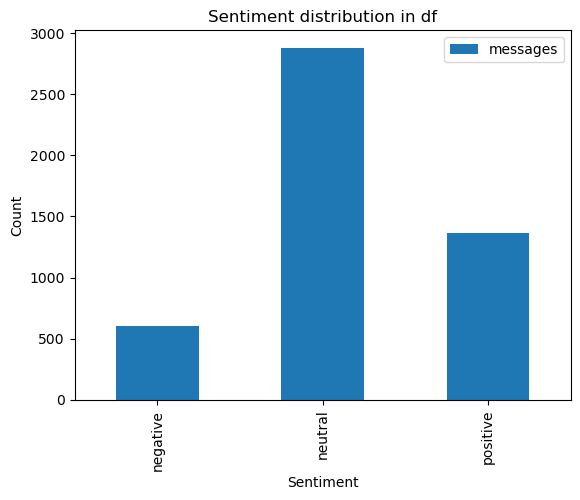

In [4]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [5]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [6]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [7]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [8]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [9]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [10]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [11]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 1
    else:
        return 2

In [12]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [13]:
df['labels'].head(3)

0    1
1    1
2    0
Name: labels, dtype: int64

Number of rows per sentiment:
1    2879
2    1363
0     604
Name: labels, dtype: int64


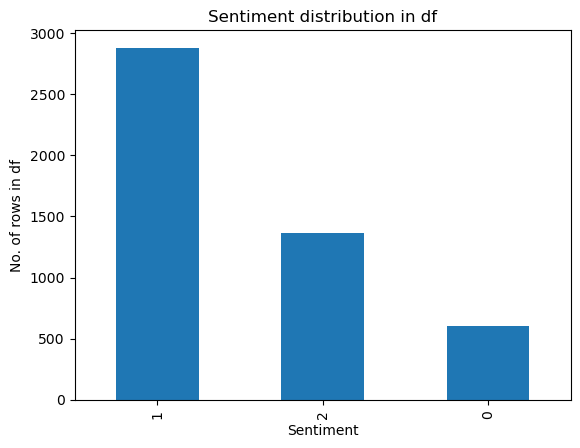

In [14]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [15]:
df.to_csv('preprocessed-text.csv', sep = ',')

In [16]:
# prep for word2vec generation

In [17]:
df[['messages']].head()

,messages
0,"[accord, gran, company, no, plan, move, produc..."
1,"[technopoli, plan, develop, stage, area, no, l..."
2,"[international, electronic, industry, company,..."
3,"[new, production, plant, company, would, incre..."
4,"[accord, company, update, strategy, year, basw..."


code below from: https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim/52067942

In [18]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss() 
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [19]:
corpus = pd.Series(df['messages'].values)

In [20]:
# init word2vec class
w2v_model = Word2Vec(vector_size=300, # 300 dimension vector
                     window=15, # how many neighbors around a particular word
                     min_count=2, # the word needs to appear at least two times in the corpus
                     workers=20, # speed of training
                     sg=1, # sg=1 means this is a skip-gram model
                     negative=5, # num of negative samples
                     sample=1e-5) # sampling rate


# build vovab
w2v_model.build_vocab(corpus)
  
# train the w2v model
start = time.time()
w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, #num of training samples
                epochs=20, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()

print("elapsed time in seconds: " + str(end-start))
# save the word2vec model
w2v_model.save('fin_word2vec20.model')

Loss after epoch 0: 17930.412109375
Loss after epoch 1: 32826.916015625
Loss after epoch 2: 21228.5078125
Loss after epoch 3: 19308.1640625
Loss after epoch 4: 33064.453125
Loss after epoch 5: 19698.03125
Loss after epoch 6: 41035.171875
Loss after epoch 7: 31949.9375
Loss after epoch 8: 31865.421875
Loss after epoch 9: 22720.140625
Loss after epoch 10: 15995.625
Loss after epoch 11: 30554.34375
Loss after epoch 12: 16702.34375
Loss after epoch 13: 27159.65625
Loss after epoch 14: 14061.78125
Loss after epoch 15: 17458.25
Loss after epoch 16: 24684.0
Loss after epoch 17: 16403.125
Loss after epoch 18: 12053.40625
Loss after epoch 19: 13753.40625
elapsed time in seconds: 0.42357611656188965


In [21]:
fin_w2v_model = Word2Vec.load('fin_word2vec20.model')
words = list(fin_w2v_model.wv.index_to_key)
print('Word2Vec Model Exploration:')
print("Vocab size: " +str(len(words)))

w1= 'buy'
print("Top 3 words similar to buy:",\
     fin_w2v_model.wv.most_similar(positive= w1, topn=3))

w2= 'sell'
print("Top 3 words similar to sell:",\
     fin_w2v_model.wv.most_similar(positive= w2, topn=3))

print("Similarity between 'buy' and 'profit'",\
     str(fin_w2v_model.wv.similarity("buy", "profit")))

print("Similarity between 'sell' and 'loss'",\
     str(fin_w2v_model.wv.similarity("sell", "loss")))

print("Vector distance of 'buy' and 'sell'",\
     str(fin_w2v_model.wv.distance("buy", "sell")))

print("Vector distance of 'profit' and 'loss'",\
     str(fin_w2v_model.wv.distance("profit", "loss")))

print("Vector representation of 'asset':",\
      fin_w2v_model.wv.get_vector("asset"))

Word2Vec Model Exploration:
Vocab size: 3751
Top 3 words similar to buy: [('use', 0.999298632144928), ('corporation', 0.9992895126342773), ('company', 0.9992879033088684)]
Top 3 words similar to sell: [('solution', 0.9993676543235779), ('group', 0.9993588328361511), ('say', 0.9993565678596497)]
Similarity between 'buy' and 'profit' 0.998351
Similarity between 'sell' and 'loss' 0.99792516
Vector distance of 'buy' and 'sell' 0.0009331703186035156
Vector distance of 'profit' and 'loss' 0.0025137662887573242
Vector representation of 'asset': [ 0.03224398  0.04574199  0.02667524  0.05739136 -0.00488926 -0.05391495
  0.03333474  0.10876666  0.01537139 -0.02165199 -0.06541733 -0.08100867
  0.05576432 -0.0041347  -0.04632616 -0.0180424  -0.02840301 -0.04699141
  0.03354304 -0.00966804 -0.04398154 -0.02397552  0.04561507  0.03628644
  0.08118854  0.01115513 -0.02886608  0.01129484 -0.02897484  0.00560454
 -0.05394715 -0.03804927 -0.00976466 -0.01619272 -0.019957    0.00490861
  0.01090157 -0.05

**Results:**

Perhaps most notably is the size of the vocabulary. 3745 is not a large word count; chances are the results would be overfit to this specific set of sentences. As always, to have a truly predictive model, far more data would be required.

To access a pretrained Word2Vec model, Google's can be accessed in the following manner:

```python
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
```

In [22]:
word_vec_dict={}
for word in words:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  3751


### Preparation of the Gensim Word2Vec Embedding Layer for Keras

In [23]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [24]:
embedding_layer = gensim_to_keras_embedding(fin_w2v_model, train_embeddings=True)

In [25]:
print(embedding_layer)

### Keras Sentence Tokenizer

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [27]:
tokenizer= Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df.messages.values)

In [28]:
word_index = tokenizer.word_index

In [29]:
print(word_index['short'])

684


In [30]:
len(word_index)

7393

In [31]:
df['keras_tokens'] = df['messages'].apply(tokenizer.texts_to_sequences)

In [32]:
type(df.keras_tokens[0][0])

list

In [33]:
## The goal here is to unpack the list of lists, which is generated by 'tokenizer.texts_to_sequences'

def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [34]:
test_sentence1 = list(traverse(df.keras_tokens[0]))
test_sentence1

[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, 142]

In [35]:
df['keras_tokens'] = df['keras_tokens'].apply(traverse).apply(list)

In [36]:
df.head(2)

,labels,messages,keras_tokens
0,1,"[accord, gran, company, no, plan, move, produc...","[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, ..."
1,1,"[technopoli, plan, develop, stage, area, no, l...","[1087, 80, 104, 933, 89, 193, 868, 482, 1283, ..."


### Train Test Split

In [37]:
df.head(2)

,labels,messages,keras_tokens
0,1,"[accord, gran, company, no, plan, move, produc...","[63, 2670, 3, 193, 80, 366, 54, 103, 2161, 3, ..."
1,1,"[technopoli, plan, develop, stage, area, no, l...","[1087, 80, 104, 933, 89, 193, 868, 482, 1283, ..."


In [46]:
## train test split of keras tokens

In [38]:
print(len(df.keras_tokens.values))

4846


In [39]:
print(len(df.labels.values))

4846


In [40]:
X_keras = df.keras_tokens.values
y = df.labels.values

In [41]:
X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X_keras, y, test_size=.3, random_state=42)


print(X_train_keras.shape, X_test_keras.shape)

(3392,) (1454,)


## Pad Sequences

In [42]:
padded_train_seq = pad_sequences(X_train_keras, maxlen=50, padding='post')
padded_test_seq = pad_sequences(X_test_keras, maxlen=50, padding='post')

In [43]:
print(padded_train_seq.shape)
print(y_train_keras.shape)
print(padded_test_seq.shape)
print(y_test_keras.shape)

(3392, 50)
(3392,)
(1454, 50)
(1454,)


### Basic Sentiment Network Using Word2Vec Embedding Layer

In [44]:
# Note the embedding layer is first, 
# and the output 3 nodes as it is either 0,2, or 4(negative, neutral, or positive)
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(3, activation = tf.nn.softmax)
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         1125300   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 60)                18060     
                                                                 
 dense_1 (Dense)             (None, 3)                 183       
                                                                 
Total params: 1,143,543
Trainable params: 1,143,543
Non-trainable params: 0
_________________________________________________________________


2022-09-03 10:33:41.837387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Run the Model

In [45]:
num_epochs = 10
model.fit(x= padded_train_seq, y= y_train_keras, epochs=num_epochs, validation_data=(padded_test_seq, y_test_keras))

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/embedding/embedding_lookup' defined at (most recent call last):
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/92/fmsgf0056l97n6qst76j75sm0000gp/T/ipykernel_35963/4015092028.py", line 2, in <cell line: 2>
      model.fit(padded_train_seq, y_train_keras, epochs=num_epochs, validation_data=(padded_test_seq, y_test_keras))
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kevinkwasnik/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential/embedding/embedding_lookup'
indices[16,3] = 5062 is not in [0, 3751)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_train_function_690]

In [ ]:
--

### Word2Vec sentence tokens

In [ ]:
def word_token(lis):
    token_ls = []
    try:
        for i in lis:
            token_ls.append(np.mean(fin_w2v_model.wv[i]))
    except:
        pass
    return token_ls

In [ ]:
my_ls = ['tree', 'house', 'fun', 'ecb']
print(word_token(my_ls))

In [ ]:
df['w2v_tokens'] = df.messages.apply(word_token)

In [ ]:
len_ls = []
for i in df.w2v_tokens:
    len_ls.append(len(i))
    
print(max(len_ls))

In [ ]:
avg_length = 0.0
max_length = 0

for i in df.w2v_tokens:
    if len(i) > max_length:
        max_length = len(i)
    avg_length += float(len(i))
    
print('Average headline length: {}'.format(avg_length / float(len(df.w2v_tokens))))
print('Max headline length: {}'.format(max_length))

In [ ]:
### above is fine
### below needs to be redone

code below from: https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim/52067942

**Results:**

Perhaps most notably is the size of the vocabulary. 3056 is not a large word count; chances are the results would be overfit to this specific set of sentences. As always, to have a truly predictive model, far more data would be required. 

To access a pretrained Word2Vec model, Google's can be accessed in the following manner:

```python

import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
```

In [ ]:
from sklearn.manifold import TSNE  ## reduction of dimensions

Visualization of Word2Vec embeddings from documentation at:
https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

In [ ]:

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(fin_w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow